### This notebook is part of Weekly Retail Sales Forecasting Project.
##### It contains the code to perform Data Cleaning on all the 3 files and we will be merging all the 3 files to create one consolidated dataset having all the attributes

In [2]:
#pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score,auc,confusion_matrix,classification_report,precision_score,roc_curve,roc_auc_score,recall_score,f1_score,precision_score
from sklearn import metrics
import missingno as mn
import math as m
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl',8)

### 1. Reading the Features csv file into a DF for cleaning it

In [79]:
features_df = pd.read_csv("features.csv")
print(features_df.head())
print(features_df.shape)

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  
(8190, 12)


### We can observe that the attributes "Markdown1, Markdown2, Markdown3, Markdown4, Markdown5, CPI & Unemployment" have missing values in them 

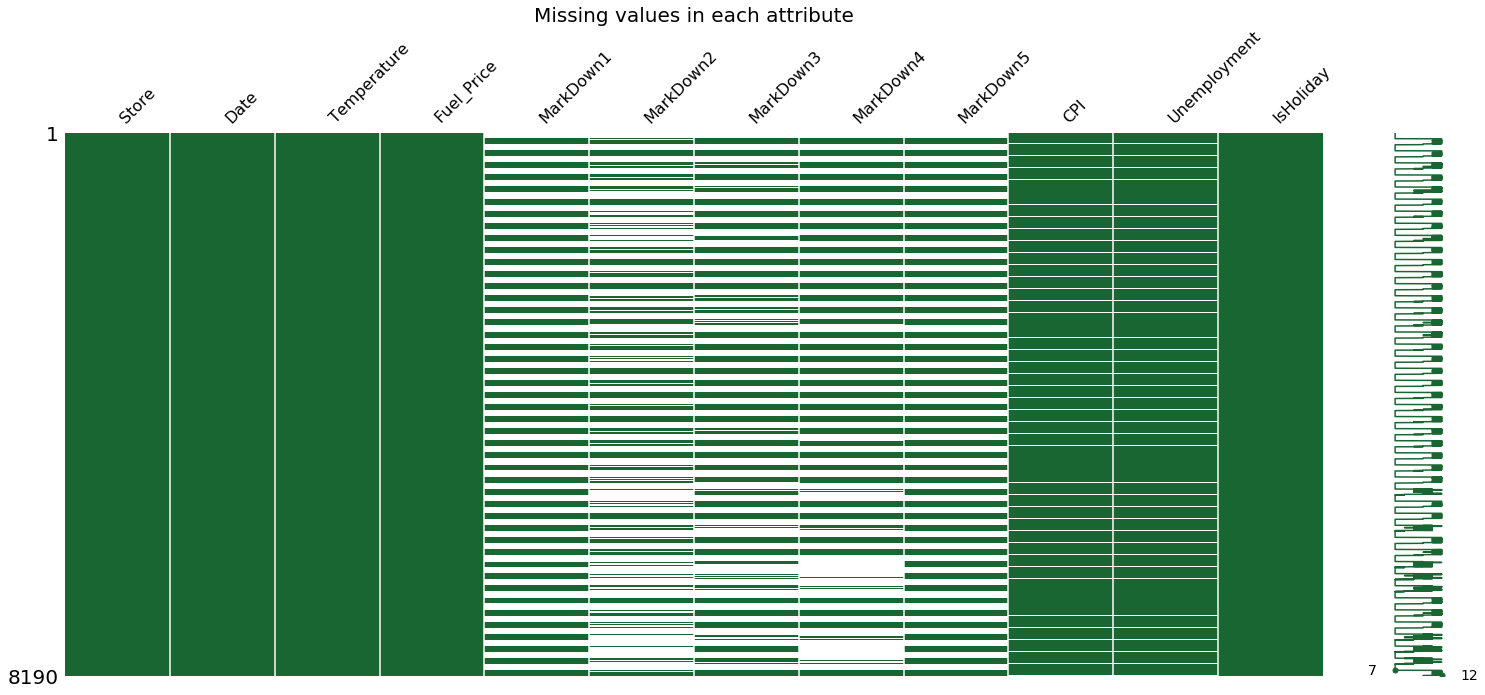

In [80]:
mn.matrix(features_df,color=(0.1,0.4,0.2))
plt.title('Missing values in each attribute',fontsize=20)
plt.show()

#### Percentage of missing values in each column

In [81]:
(features_df.isnull().sum(axis=0)/max(features_df.count(axis=0)))*100

Store            0.000000
Date             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       50.769231
MarkDown2       64.334554
MarkDown3       55.885226
MarkDown4       57.704518
MarkDown5       50.549451
CPI              7.142857
Unemployment     7.142857
IsHoliday        0.000000
dtype: float64

##### *Dropping Markdown1, Markdown2, Markdown3, Markdown4 and Markdown5 as the Null values are more than 50%. We don't want to induce more Bias into the data by imputing values*

In [82]:
features_df =  features_df.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

##### *Converting IsHoliday column into binary value*

In [83]:
cleanup_nums = {False: 0, True: 1}
features_df.IsHoliday.map(cleanup_nums)

0       0
1       1
2       0
3       0
4       0
       ..
8185    0
8186    0
8187    0
8188    0
8189    0
Name: IsHoliday, Length: 8190, dtype: int64

##### 585 holiday weeks

In [84]:
sum(features_df['IsHoliday']==1)

585

##### *Filling the Null values with the median values of the respective columns*

In [85]:
features_df['CPI'] = features_df['CPI'].fillna(features_df['CPI'].median())
features_df['Unemployment'] = features_df['Unemployment'].fillna(features_df['Unemployment'].median())

#### Checking for any outliers*

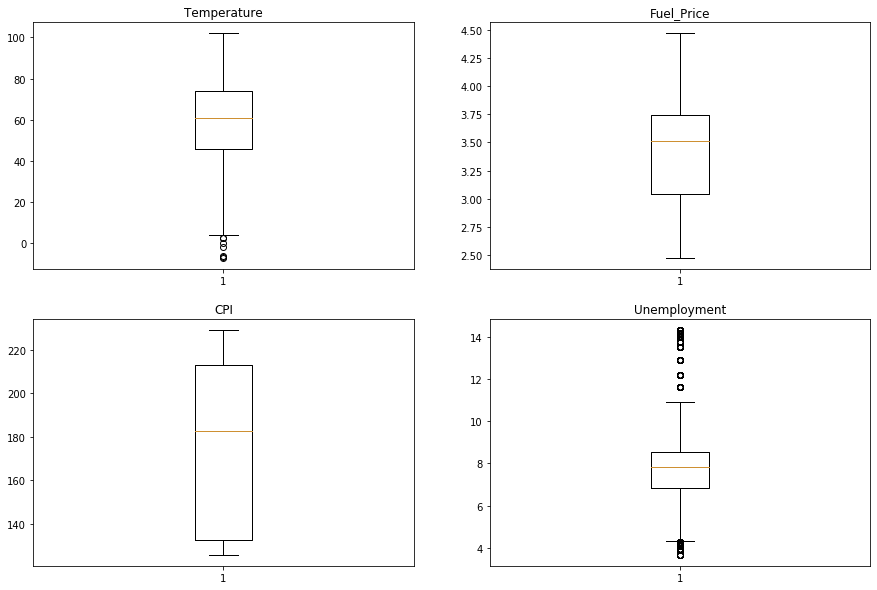

In [86]:
num_var = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
plt.figure(figsize=(15,10))
for i in range(len(num_var)):
    plt.subplot(2,2,i+1)
    plt.boxplot(features_df[num_var[i]])
    plt.title(num_var[i])

#### *We see that there are outliers in temperature and Unemployment.*
#### *To remove the outliers we use the inter-quartile method.*

In [87]:
def outlier(a):
    sorted(a)
    Q1,Q3 = np.percentile(a , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

def clip_series(s, lower, upper):
    clipped = s.clip(lower, upper)
    return clipped

for i in ['Temperature', 'Unemployment']:
    lowerbound,upperbound = outlier(features_df[i])
    features_df[i] = clip_series(features_df[i],lowerbound,upperbound)

In [88]:
features_df

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,211.350143,8.106,False
...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,182.764003,7.806,False
8186,45,2013-07-05,77.50,3.614,182.764003,7.806,False
8187,45,2013-07-12,79.37,3.614,182.764003,7.806,False
8188,45,2013-07-19,82.84,3.737,182.764003,7.806,False


*Table is at Store & Date level with no duplicates*

In [89]:
print(sum(features_df.groupby(['Store','Date']).size()),len(features_df))

8190 8190


In [90]:
features_df.to_csv('treated_features.csv', index=False)

###### ***Features Dataframe is processed***

### 2. Reading the weekly sales csv file into a DF for cleaning it

In [91]:
weekly_store_dept_sales_df = pd.read_csv("train.csv")
print(weekly_store_dept_sales_df.head())
print(weekly_store_dept_sales_df.shape)

   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1   2/5/2010      24924.50      False
1      1     1  2/12/2010      46039.49       True
2      1     1  2/19/2010      41595.55      False
3      1     1  2/26/2010      19403.54      False
4      1     1   3/5/2010      21827.90      False
(421570, 5)


#### Replacing True/False values with 1/0 values

In [92]:
cleanup_nums = {False: 0, True: 1}
weekly_store_dept_sales_df.IsHoliday.map(cleanup_nums)

0         0
1         1
2         0
3         0
4         0
         ..
421565    0
421566    0
421567    0
421568    0
421569    0
Name: IsHoliday, Length: 421570, dtype: int64

In [93]:
sum(weekly_store_dept_sales_df['IsHoliday']==1)

29661

##### No missing values in this dataset

In [94]:
(weekly_store_dept_sales_df.isnull().sum(axis=0)/max(weekly_store_dept_sales_df.count(axis=0)))*100

Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
dtype: float64

*Negative value in sales because of customer returns > items sold*

In [95]:
print(min(weekly_store_dept_sales_df.Weekly_Sales),max(weekly_store_dept_sales_df.Weekly_Sales))

-4988.94 693099.36


*Confirming that there are no duplicate records and the dataset is at 'Store','Dept' & 'Date' level*

In [96]:
print(sum(weekly_store_dept_sales_df.groupby(['Store','Dept','Date']).size()),len(weekly_store_dept_sales_df))

421570 421570


##### *** weekly_store_dept_sales_df dataframe is processed ***

### 3. Reading the stores csv file into a DF for cleaning it

In [97]:
stores_df = pd.read_csv("stores.csv")
print(stores_df.head())
print(stores_df.shape)

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
(45, 3)


##### No missing values in this dataset

In [98]:
(stores_df.isnull().sum(axis=0)/max(weekly_store_dept_sales_df.count(axis=0)))*100

Store    0.0
Type     0.0
Size     0.0
dtype: float64

In [99]:
stores_df = pd.concat([stores_df,pd.get_dummies(stores_df.Type, prefix='Type')],axis=1)
stores_df.drop(['Type'],axis=1, inplace=True)
stores_df.head()

,Store,Size,Type_A,Type_B,Type_C
0,1,151315,1,0,0
1,2,202307,1,0,0
2,3,37392,0,1,0
3,4,205863,1,0,0
4,5,34875,0,1,0


*No dupliactes in the store level data*

In [100]:
print(sum(stores_df.groupby(['Store']).size()),len(stores_df))

45 45


*No Outliers since all the Z scores are in range*

In [101]:
print(min(stores_df['Size'] - stores_df['Size'].mean())/stores_df['Size'].std(ddof=0),
      max(stores_df['Size'] - stores_df['Size'].mean())/stores_df['Size'].std(ddof=0))

-1.5117952448249015 1.4154872744195803


##### *** stores dataframe is processed ***

### 4. Merging the 3 dataframes into 1

In [102]:
new_df = pd.merge(weekly_store_dept_sales_df, stores_df,  how='inner', left_on=['Store'], right_on = ['Store'])
new_df['Date'] = pd.to_datetime(new_df.Date)
features_df['Date'] = pd.to_datetime(features_df.Date)
sales_forecasting_df = pd.merge(new_df,features_df, how = 'inner', left_on=['Store','Date'], right_on = ['Store','Date'])

In [103]:
print(sales_forecasting_df.head())
print(sales_forecasting_df.shape)

   Store  Dept       Date  Weekly_Sales  IsHoliday_x    Size  Type_A  Type_B  \
0      1     1 2010-02-05      24924.50        False  151315       1       0   
1      1     2 2010-02-05      50605.27        False  151315       1       0   
2      1     3 2010-02-05      13740.12        False  151315       1       0   
3      1     4 2010-02-05      39954.04        False  151315       1       0   
4      1     5 2010-02-05      32229.38        False  151315       1       0   

   Type_C  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday_y  
0       0        42.31       2.572  211.096358         8.106        False  
1       0        42.31       2.572  211.096358         8.106        False  
2       0        42.31       2.572  211.096358         8.106        False  
3       0        42.31       2.572  211.096358         8.106        False  
4       0        42.31       2.572  211.096358         8.106        False  
(421570, 14)


*Dropping the extra column obtained on joining*

In [104]:
sales_forecasting_df =  sales_forecasting_df.drop(columns=['IsHoliday_x'])

*Converting IsHoliday column to int*

In [111]:
sales_forecasting_df["IsHoliday_y"] = sales_forecasting_df["IsHoliday_y"].astype(int)
sales_forecasting_df = sales_forecasting_df.rename(columns={"IsHoliday_y": "IsHoliday"})

*Sorting the data by Store, Department & Date*

In [116]:
sales_forecasting_df = sales_forecasting_df.sort_values(['Store', 'Dept','Date'], ascending=[True, True,True])
sales_forecasting_df.head(10)

,Store,Dept,Date,Weekly_Sales,Size,Type_A,Type_B,Type_C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,151315,1,0,0,42.31,2.572,211.096358,8.106,0
73,1,1,2010-02-12,46039.49,151315,1,0,0,38.51,2.548,211.242170,8.106,1
145,1,1,2010-02-19,41595.55,151315,1,0,0,39.93,2.514,211.289143,8.106,0
218,1,1,2010-02-26,19403.54,151315,1,0,0,46.63,2.561,211.319643,8.106,0
290,1,1,2010-03-05,21827.90,151315,1,0,0,46.50,2.625,211.350143,8.106,0
363,1,1,2010-03-12,21043.39,151315,1,0,0,57.79,2.667,211.380643,8.106,0
436,1,1,2010-03-19,22136.64,151315,1,0,0,54.58,2.720,211.215635,8.106,0
508,1,1,2010-03-26,26229.21,151315,1,0,0,51.45,2.732,211.018042,8.106,0
580,1,1,2010-04-02,57258.43,151315,1,0,0,62.27,2.719,210.820450,7.808,0
652,1,1,2010-04-09,42960.91,151315,1,0,0,65.86,2.770,210.622857,7.808,0


In [117]:
sales_forecasting_df.to_csv('sales_forecasting.csv', index=False)

#### End of Creating the final cleaned master dataframe